In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

In [13]:
#Affichage des 5 premières lignes de l'ensemble de données d'actualités réelles
real.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [14]:
#Affichage des 5 premières lignes de l'ensemble de données de fake news
fake.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [15]:
#Forme d'un ensemble de données d'actualités réelles et de données de fake news
print("Real news: ",real.shape)
print("Fake News: ", fake.shape)



Real news:  (21417, 4)
Fake News:  (23481, 4)


In [16]:
#Attribution d'une valeur de 0 à toutes les données d'actualité réelles et les placer dans la trame de données

class0 = []

for i in range(21417):
  class0.append(0)

real.insert(4, "class", class0, True)

In [17]:
#Attribution d'une valeur de 1 à toutes les fausses données d'actualités et les placer dans la trame de données
class1 = []

for i in range(23481):
  class1.append(1)

fake.insert(4, "class", class1, True)

In [18]:
#Concactiné les fausses nouvelles et les vraies nouvelles en 1 ensemble de données total

total = pd.concat([real,fake])
total = total.sample(frac = 1)

In [19]:
#total
total.shape

(44898, 5)

In [20]:
pd.set_option('display.width', total.shape[0])
total.head()

,title,text,subject,date,class
12431,U.S. criticizes Poland for fining U.S.-owned b...,WARSAW (Reuters) - The United States criticize...,worldnews,"December 13, 2017",0
7627,Scooby Doo’s ‘Mystery Machine’ Involved In Cr...,File this one under: WTF?!A woman driving a va...,News,"March 8, 2016",1
9660,"Former Texas Gov. Perry endorses Trump, says o...",WASHINGTON (Reuters) - Former Texas Governor R...,politicsNews,"May 5, 2016",0
3295,Russia may seize U.S. property if its own comp...,MOSCOW (Reuters) - Russia may seize U.S. diplo...,politicsNews,"June 9, 2017",0
11591,Turkey's Erdogan says expects U.S. to rescind ...,ISTANBUL (Reuters) - Turkish President Tayyip ...,worldnews,"December 21, 2017",0


In [21]:
#Extraire uniquement les valeurs pour le titre (entrée) et la classe (sortie)
data = total[['title','class']]
data.head()

,title,class
12431,U.S. criticizes Poland for fining U.S.-owned b...,0
7627,Scooby Doo’s ‘Mystery Machine’ Involved In Cr...,1
9660,"Former Texas Gov. Perry endorses Trump, says o...",0
3295,Russia may seize U.S. property if its own comp...,0
11591,Turkey's Erdogan says expects U.S. to rescind ...,0


In [22]:
#Nombre de caractères des titres - Min, Moyenne, Max
print('Mean Length', data['title'].apply(len).mean())
print('Min Length', data['title'].apply(len).min())
print('Max Length', data['title'].apply(len).max())

Mean Length 80.11171989843646
Min Length 8
Max Length 286


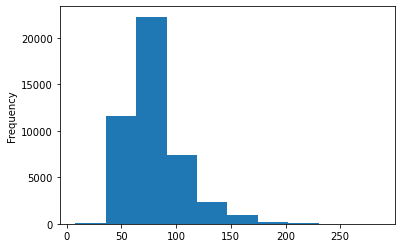

In [23]:
# tracer la fréquence des caractères sur un histogramme
import seaborn as sns

x = data['title'].apply(len).plot.hist()

In [27]:
#Extraction de tableaux numpy pour le titre et les classes
titles = data["title"].values
labels = data["class"].values


In [29]:
from sklearn.model_selection import train_test_split
title_train, title_test, y_train, y_test = train_test_split(titles, labels, test_size=0.2, random_state=1000)


In [30]:
!pip install tensorflow-text
import tensorflow_hub as hub
import tensorflow_text as text

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=907e57f3ba7349ba230a8686d219aaf11331d7de9873f39556aa1209f50bd084
  Stored in directory: c:\users\nesrine\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [31]:
#Télécharger le préprocesseur bert et l'encodeur bert depuis tensorflow_hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [32]:
def embed(headlines):
  processed = bert_preprocess(headlines)
  return bert_encoder(processed)['pooled_output']

In [33]:
import tensorflow as tf

# Couches d'entrées
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='news')

# couches de Bert
processed = bert_preprocess(input_layer)
output = bert_encoder(processed)

# Neural Network Layers

layer = tf.keras.layers.Dropout(0.2, name='dropout')(output['pooled_output'])
layer = tf.keras.layers.Dense(10,activation='relu', name='hidden')(layer)
layer = tf.keras.layers.Dense(1,activation='sigmoid', name='output')(layer)


model = tf.keras.Model(inputs=[input_layer],outputs=[layer])

In [34]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['news[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
#Compiler le modèle sur l'optimiseur adam, la perte de binary_crossentropy et les mesures de précision

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#Train modèle sur 5 époquesépoques
model.fit(title_train,y_train,epochs=5)


Epoch 1/5
 214/1123 [====>.........................] - ETA: 1:47:20 - loss: 0.4703 - accuracy: 0.7796

In [ ]:
#Évaluer le modèle sur des données de test
model.evaluate(title_test,y_test)
